In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import re

from datetime import datetime

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import pandas as pd

plt.rcParams.update({'font.size': 10})

In [5]:
def parse_timestamp(fname):
    m = re.search(r'T(\d{8})_(\d{6})M', fname.name)
    if m:
        return datetime.strptime(m.group(1) + m.group(2), '%Y%m%d%H%M%S')
    return None

def extract_all_features(img):
    """Extract features optimized for MAGIC telescope mirror images."""
    features = {}
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # ── Mask out central camera housing ──
    mask = np.ones((h, w), dtype=np.uint8) * 255
    cam_y, cam_x = int(h * 0.38), int(w * 0.52)
    cv2.circle(mask, (cam_x, cam_y), int(min(h,w)*0.12), 0, -1)
    
    valid = gray[mask > 0]

    
    # ── A) GLOBAL BRIGHTNESS ──
    features['mean_brightness'] = np.mean(valid)
    features['std_brightness'] = np.std(valid)
    features['p10_brightness'] = np.percentile(valid, 10)
    features['p90_brightness'] = np.percentile(valid, 90)
    features['dynamic_range'] = features['p90_brightness'] - features['p10_brightness']

    # ── B) LENS FLARE / DIRECT SUN DETECTION ──
    # Key insight: lens flare creates high-saturation, high-value pixels
    # that are warm-colored (yellow/orange), unlike regular mirror reflections

    # Warm bright pixels (sun/flare signature)
    hue = hsv[:,:,0].astype(float)
    sat = hsv[:,:,1].astype(float)
    val = hsv[:,:,2].astype(float)

    # Lens flare is typically warm (H < 30 or H > 160 in OpenCV) AND bright AND saturated
    warm_bright = ((hue < 25) | (hue > 160)) & (val > 180) & (sat > 60) & (mask > 0)
    features['warm_bright_fraction'] = np.sum(warm_bright) / np.sum(mask > 0)

    # General bright + saturated (any color)
    bright_saturated = (val > 200) & (sat > 80) & (mask > 0)
    features['bright_saturated_frac'] = np.sum(bright_saturated) / np.sum(mask > 0)

    # ── C) SPATIAL ASYMMETRY ──
    # Strong indicator of directional sunlight
    left_mean = np.mean(gray[:, :w//3])
    right_mean = np.mean(gray[:, 2*w//3:])
    top_mean = np.mean(gray[:h//3, :])
    bottom_mean = np.mean(gray[2*h//3:, :])

    features['LR_asymmetry'] = left_mean - right_mean  # signed! positive = brighter left
    features['LR_asymmetry_abs'] = abs(features['LR_asymmetry'])
    features['TB_asymmetry'] = top_mean - bottom_mean
    features['TB_asymmetry_abs'] = abs(features['TB_asymmetry'])

    # ── D) SKY REGION ANALYSIS ──
    # The sky is visible in the top corners and edges
    sky_top = gray[:h//6, :]
    features['sky_brightness'] = np.mean(sky_top)
    features['sky_blue_ratio'] = np.mean(img[:h//6, :, 0]) / (np.mean(img[:h//6, :, 2]) + 1)

    # ── E) COLOR STATISTICS ──
    features['mean_saturation'] = np.mean(sat[mask > 0])
    features['mean_hue'] = np.mean(hue[mask > 0])
    features['BR_ratio'] = (np.mean(img[:,:,0].astype(float)) + 1) / (np.mean(img[:,:,2].astype(float)) + 1)

    # Lab color: a* channel (green-red axis) - warm sunlight shifts this
    features['mean_a_channel'] = np.mean(lab[:,:,1].astype(float))
    features['mean_b_channel'] = np.mean(lab[:,:,2].astype(float))  # blue-yellow axis

    # ── F) TEXTURE / EDGE METRICS ──
    # Lens flare reduces local contrast in affected areas
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features['sharpness'] = np.std(laplacian)

    # ── G) HISTOGRAM FEATURES ──
    hist = cv2.calcHist([gray], [0], mask, [256], [0, 256]).flatten()
    hist_norm = hist / (hist.sum() + 1e-6)
    features['entropy'] = -np.sum(hist_norm[hist_norm > 0] * np.log2(hist_norm[hist_norm > 0]))

    # Fraction of very dark pixels (shadow indicator)
    features['dark_fraction'] = np.sum(valid < 40) / len(valid)
    # Fraction of very bright pixels
    features['bright_fraction'] = np.sum(valid > 220) / len(valid)

    h, w = img.shape[:2]
    top = img[0:h // 3, :]

    hsv = cv2.cvtColor(top, cv2.COLOR_BGR2HSV)
    h_ch, s_ch, v_ch = cv2.split(hsv)

    mean_sat = float(np.mean(s_ch))
    mean_val = float(np.mean(v_ch))
    std_val = float(np.std(v_ch))
    overexp_pct = float(np.sum(v_ch > 250) / v_ch.size * 100)

    features['over_exposure_pct'] = overexp_pct

    return features

def extract_feature(img):
    """Extract features optimized for MAGIC telescope mirror images."""
    features = {}
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # ── Mask out central camera housing ──
    #mask = np.ones((h, w), dtype=np.uint8) * 255
    #cam_y, cam_x = int(h * 0.38), int(w * 0.52)
    #cv2.circle(mask, (cam_x, cam_y), int(min(h,w)*0.12), 0, -1)
    #valid = gray[mask > 0]
    valid = gray[0:800, :].flatten()

    # ── A) GLOBAL BRIGHTNESS ──
    features['mean_brightness'] = np.mean(valid)
    features['dynamic_range'] = features['p90_brightness'] - features['p10_brightness']

    # ── B) LENS FLARE / DIRECT SUN DETECTION ──
    # Key insight: lens flare creates high-saturation, high-value pixels
    # that are warm-colored (yellow/orange), unlike regular mirror reflections

    # Warm bright pixels (sun/flare signature)
    hue = hsv[:,:,0].astype(float)
    sat = hsv[:,:,1].astype(float)
    val = hsv[:,:,2].astype(float)

    # Lens flare is typically warm (H < 30 or H > 160 in OpenCV) AND bright AND saturated
    warm_bright = ((hue < 25) | (hue > 160)) & (val > 180) & (sat > 60) & (mask > 0)
    features['warm_bright_fraction'] = np.sum(warm_bright) / np.sum(mask > 0)

    # General bright + saturated (any color)
    bright_saturated = (val > 200) & (sat > 80) & (mask > 0)
    features['bright_saturated_frac'] = np.sum(bright_saturated) / np.sum(mask > 0)

    # ── C) SPATIAL ASYMMETRY ──
    # Strong indicator of directional sunlight
    left_mean = np.mean(gray[:, :w//3])
    right_mean = np.mean(gray[:, 2*w//3:])
    top_mean = np.mean(gray[:h//3, :])
    bottom_mean = np.mean(gray[2*h//3:, :])

    features['LR_asymmetry'] = left_mean - right_mean  # signed! positive = brighter left
    features['LR_asymmetry_abs'] = abs(features['LR_asymmetry'])
    features['TB_asymmetry'] = top_mean - bottom_mean
    features['TB_asymmetry_abs'] = abs(features['TB_asymmetry'])


    return features

def get_df_features(files_path):
    images, timestamps, labels, fnames = [], [], [], []

    for f in files[::5]:
        images.append(cv2.imread(str(f)))
        ts = parse_timestamp(f)
        labels.append(ts.strftime("%d/%m\n%H:%M"))
        fnames.append(f.name)

    all_features = []
    features_names = None

    for img in images:
        feats = extract_all_features(img)
        all_features.append(feats)
        if features_names is None:
            features_names = list(feats.keys())
    df = pd.DataFrame(all_features)
    df['fnames'] = fnames
    df['label'] = labels

    return df

In [6]:
def get_assymetry():
    # ── SPATIAL ASYMMETRY ──
    # Strong indicator of directional sunlight
    features = {}
    left_mean = np.mean(gray[:, :w//3])
    right_mean = np.mean(gray[:, 2*w//3:])
    top_mean = np.mean(gray[:h//3, :])
    bottom_mean = np.mean(gray[2*h//3:, :])

    features['LR_asymmetry'] = left_mean - right_mean  # signed! positive = brighter left
    features['LR_asymmetry_abs'] = abs(features['LR_asymmetry'])
    features['TB_asymmetry'] = top_mean - bottom_mean
    features['TB_asymmetry_abs'] = abs(features['TB_asymmetry'])
    return features
    
def detect_sun(img_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    # === Detekcja slonca: gorny pasek 8%, 10 segmentow ===
    strip = img[0:600, :]
    gray_strip = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    print(np.mean(gray_strip))
    n_seg = 5
    seg_w = w // n_seg
    seg_means = []
    for i in range(n_seg):
        seg = gray_strip[:, i * seg_w:(i + 1) * seg_w]
        seg_means.append(float(np.mean(seg)))

    arr = np.array(seg_means)
    sun_diff = float(np.max(arr) - np.median(arr))
    sun_seg = int(np.argmax(arr))
    return sun_diff

def show_images(images_list):
    fig, ax = plt.subplots(3, 6, figsize=(16, 16))
    axes = ax.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images_list[i])
        ax.set_axis_off()
        ax.set_title(labels[i])
    
    plt.tight_layout()
    plt.show()

def get_warm_bright(img):
    w, h = img.shape[0], img.shape[1]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Warm bright pixels (sun/flare signature)
    hue = hsv[:,:,0].astype(float)
    sat = hsv[:,:,1].astype(float)
    val = hsv[:,:,2].astype(float)

    # Lens flare is typically warm (H < 30 or H > 160 in OpenCV) AND bright AND saturated
    warm_bright = ((hue < 25) | (hue > 160)) & (val > 180) & (sat > 60) 
    return (np.sum(warm_bright)/(w*h))*100

In [29]:
def show_mask(img_path, mask=None, mask_fn=None, output_path="mask_preview.jpg",
              color=(0, 0, 255), alpha=0.5, show_contour=True):
    """
    Wizualizacja maski nalozonej na zdjecie.

    Parametry:
        img_path     : sciezka do zdjecia
        mask         : gotowa maska (uint8, 255=valid, 0=masked)
        mask_fn      : funkcja(img) -> mask, alternatywa do mask
        output_path  : sciezka do zapisu wyniku
        color        : kolor zamaskowanego obszaru (BGR)
        alpha         : przezroczystosc nakładki (0-1)
        show_contour : czy rysowac kontur maski

    Przyklad:
        # Z gotowa maska:
        mask = np.ones((h, w), dtype=np.uint8) * 255
        cv2.circle(mask, (400, 300), 100, 0, -1)
        show_mask("image.jpg", mask=mask)

        # Z funkcja maski:
        def my_mask(img):
            h, w = img.shape[:2]
            m = np.ones((h, w), dtype=np.uint8) * 255
            cv2.circle(m, (int(w*0.52), int(h*0.38)), int(min(h,w)*0.12), 0, -1)
            return m

        show_mask("image.jpg", mask_fn=my_mask)
    """
    img = cv2.imread(str(img_path))
    if img is None:
        print("Nie mozna wczytac: " + str(img_path))
        return

    if mask is None and mask_fn is not None:
        mask = mask_fn(img)

    if mask is None:
        print("Podaj mask albo mask_fn")
        return

    h, w = img.shape[:2]
    vis = img.copy()

    # Polprzezroczysta nakladka kolorem
    overlay = img.copy()
    overlay[mask == 0] = color
    cv2.addWeighted(overlay, alpha, vis, 1 - alpha, 0, vis)

    # Kontur maski
    if show_contour:
        contours, _ = cv2.findContours(
            (255 - mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours, -1, (0, 255, 0), 3)

    cv2.imwrite(str(output_path), vis)
    print("Zapisano: %s (%dx%d)" % (output_path, w, h))
    return vis
    




In [8]:
img_dir = Path("/media/pgliwny/ADATA HD3303/Computer_Vision_system/data/MAGIC/IRCam/IRCamera/2025/11/10/")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))

In [109]:
img_dir = Path("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/12/22")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))

Zapisano: output/mask_preview.jpg (1920x2560)


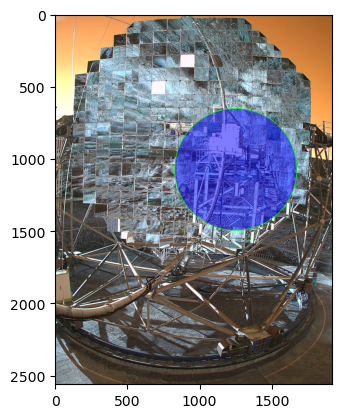

In [33]:
def camera_mask(img):
    h, w = img.shape[:2]
    m = np.ones((h, w), dtype=np.uint8) * 255
    cam_y, cam_x = int(h * 0.42), int(w * 0.65)
    cv2.circle(m, (cam_x, cam_y), int(min(h, w) * 0.22), 0, -1)
    return m
    
o = show_mask(str(files[10]), mask_fn=camera_mask, output_path="output/mask_preview.jpg")
plt.imshow(o)

177.1124765625
64.96840711805555


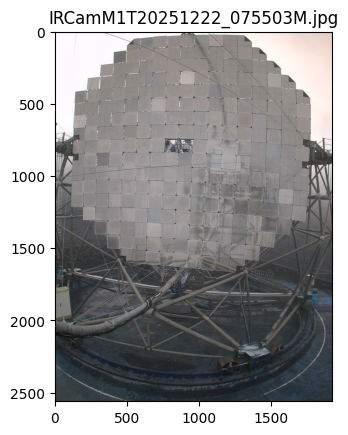

In [110]:
img_path = files[5]
img = cv2.imread(img_path)
plt.title(str(img_path).split("/")[-1])
plt.imshow(img)
print(detect_sun(img_path))

In [ ]:
img = cv2.imread(img_path)

In [21]:
detect_sun(files[15])

56.1958486519608

IRCamM1T20251222_152503M.jpg


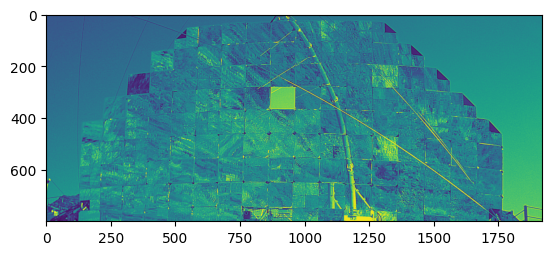

np.float64(0.0037109375)

In [118]:
img_path = files[50]
img = cv2.imread(img_path)
print(str(img_path).split("/")[-1])
strip = img[0:800, :]
gray_strip = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots()
ax.imshow(gray_strip)
plt.show()
get_warm_bright(strip)

In [97]:
np.sum(w)/(w.shape[0]*w.shape[1])

np.float64(2.604166666666667e-05)

In [78]:
get_warm_bright(strip)

np.int64(134)

In [66]:
gray_strip.shape

(800, 1920)

(array([  4264.,  27915., 221099., 434714., 259634.,  62218.,  22760.,
         11445.,  14765., 477186.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

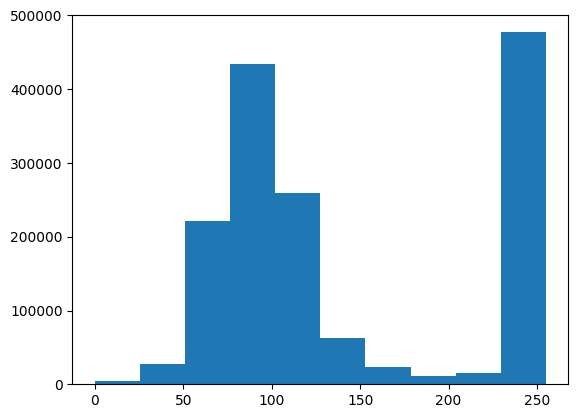

In [67]:
plt.hist(gray_strip.flatten())

In [41]:
np.mean(gray_strip)

np.float64(152.10628645833333)

In [8]:
img_dir = Path("/media/pgliwny/ADATA HD3303/Computer_Vision_system/data/MAGIC/IRCam/IRCamera/2025/11/10/")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))
df_feat_11_10 = get_df_features(files)

Premature end of JPEG file


In [9]:
img_dir = Path("/media/pgliwny/ADATA HD3303/Computer_Vision_system/data/MAGIC/IRCam/IRCamera/2025/11/12/")
files = sorted(img_dir.glob("IRCamM1T*.jpg"))
df_feat_11_12 = get_df_features(files)

In [10]:
df_feat_11_10.keys()

Index(['mean_brightness', 'std_brightness', 'p10_brightness', 'p90_brightness',
       'dynamic_range', 'warm_bright_fraction', 'bright_saturated_frac',
       'LR_asymmetry', 'LR_asymmetry_abs', 'TB_asymmetry', 'TB_asymmetry_abs',
       'sky_brightness', 'sky_blue_ratio', 'mean_saturation', 'mean_hue',
       'BR_ratio', 'mean_a_channel', 'mean_b_channel', 'sharpness', 'entropy',
       'dark_fraction', 'bright_fraction', 'over_exposure_pct', 'fnames',
       'label'],
      dtype='object')

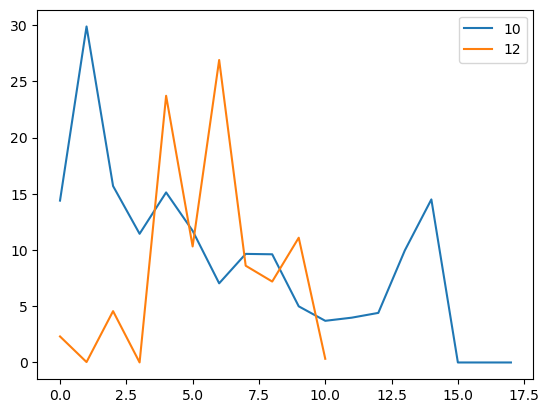

In [12]:
df_feat_11_10['over_exposure_pct'].plot(label="10")
df_feat_11_12['over_exposure_pct'].plot(label="12")
plt.legend()

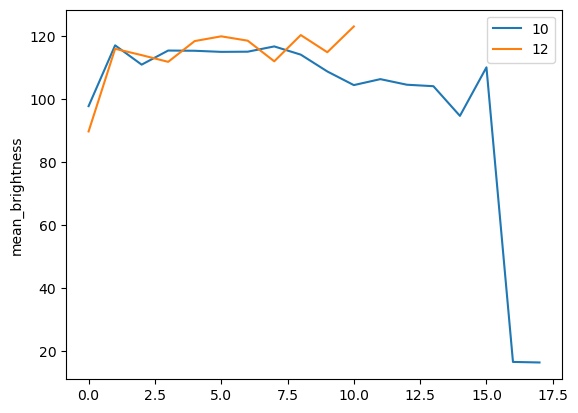

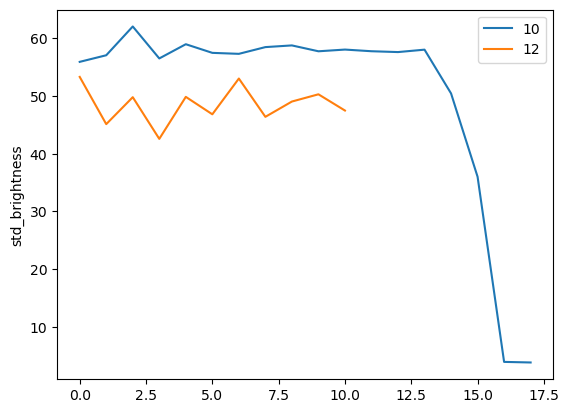

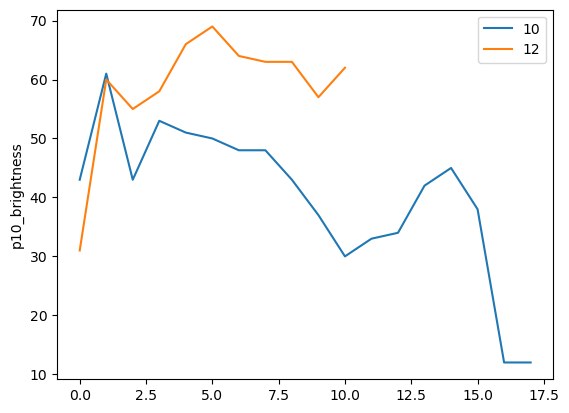

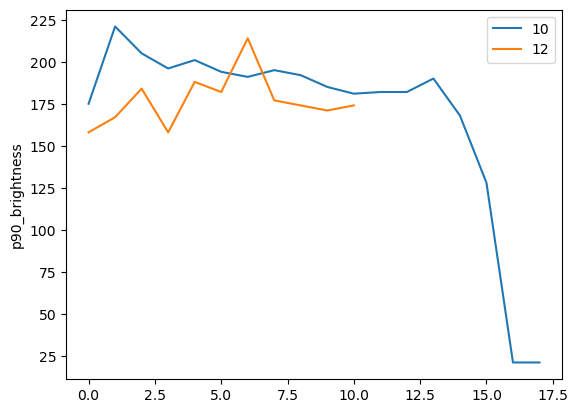

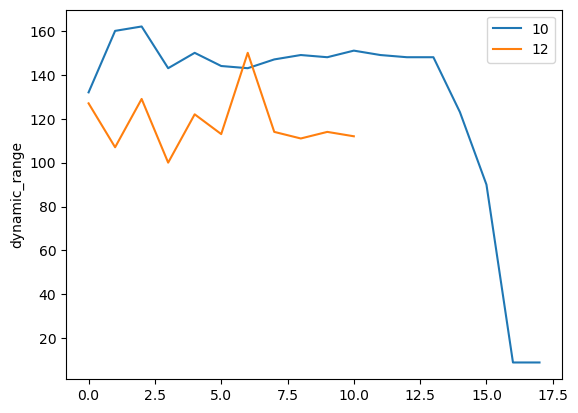

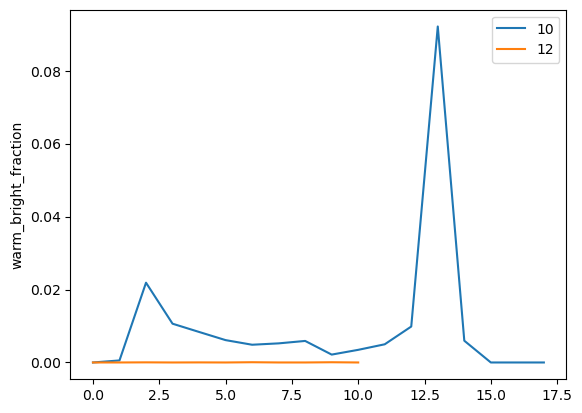

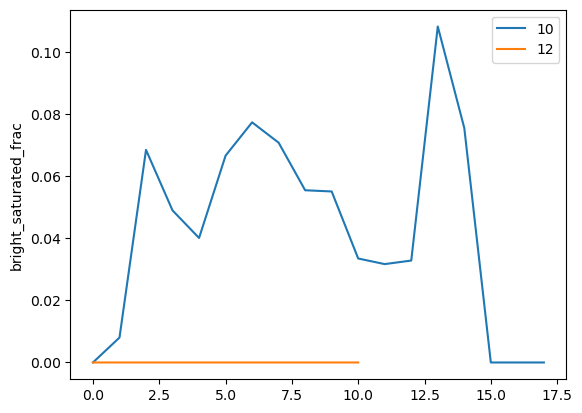

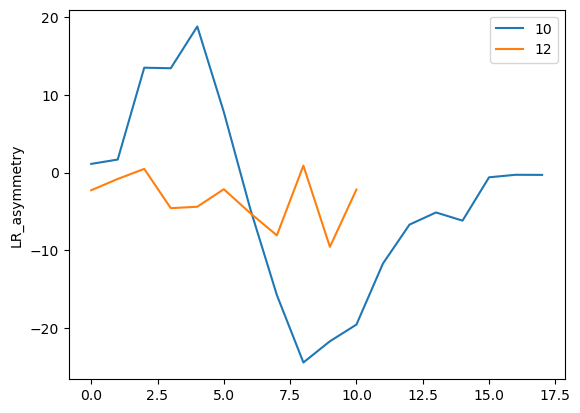

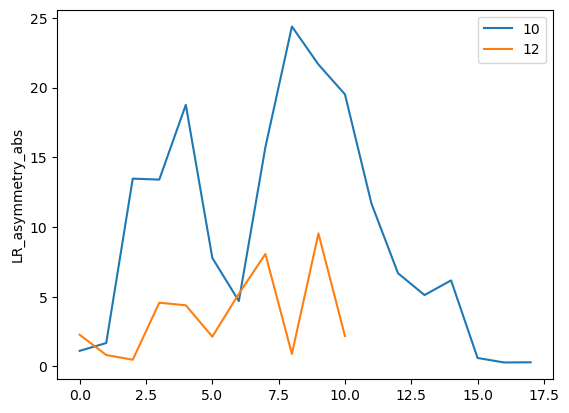

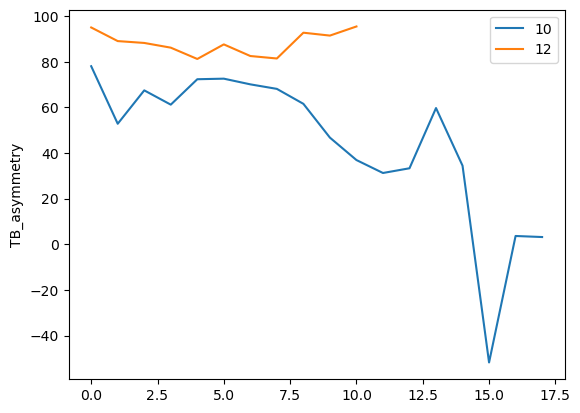

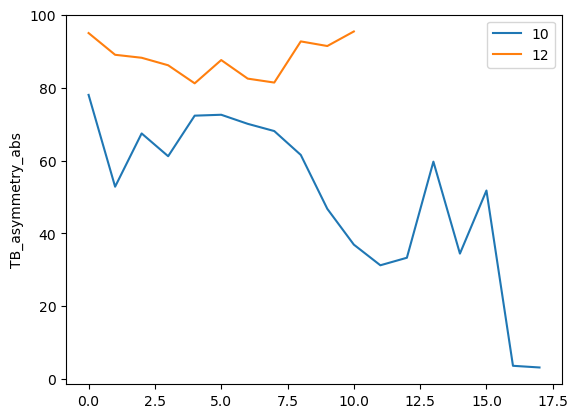

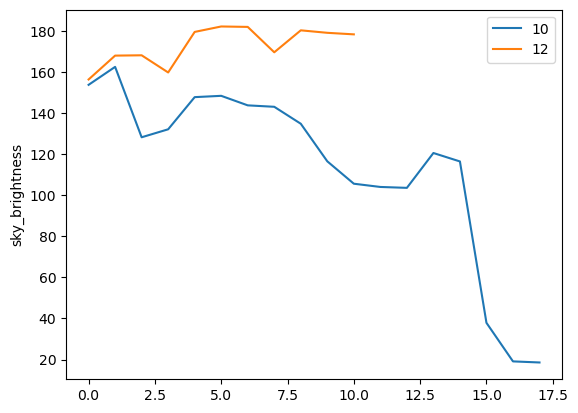

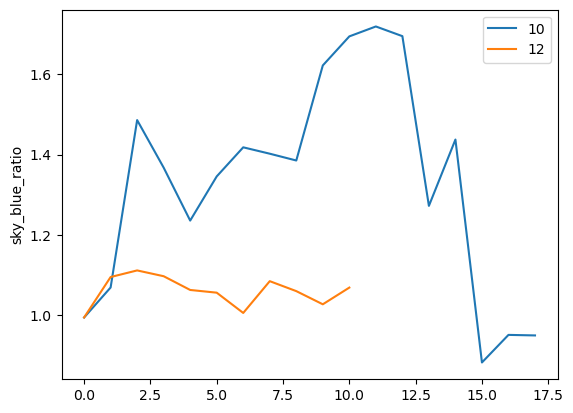

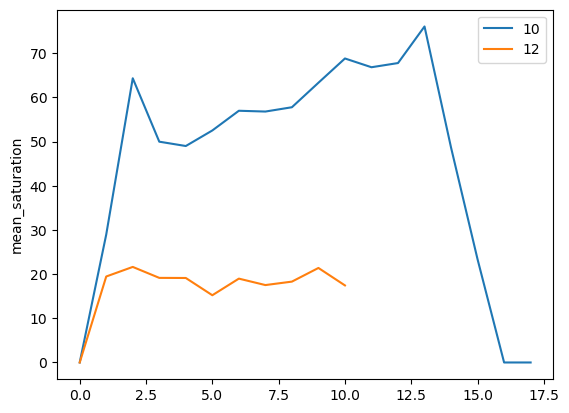

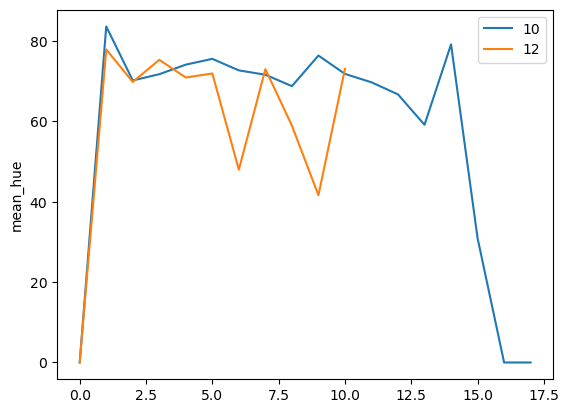

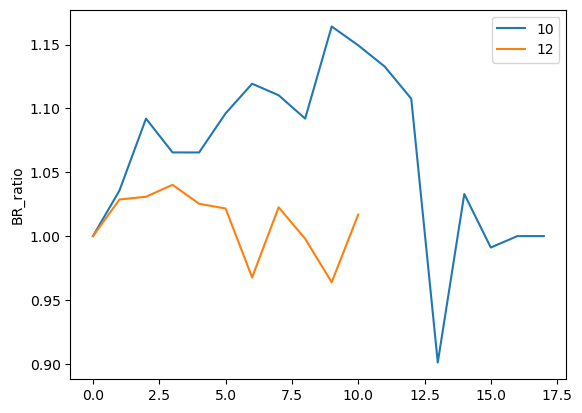

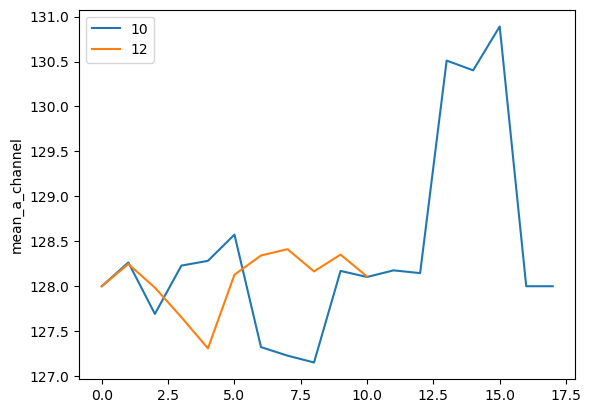

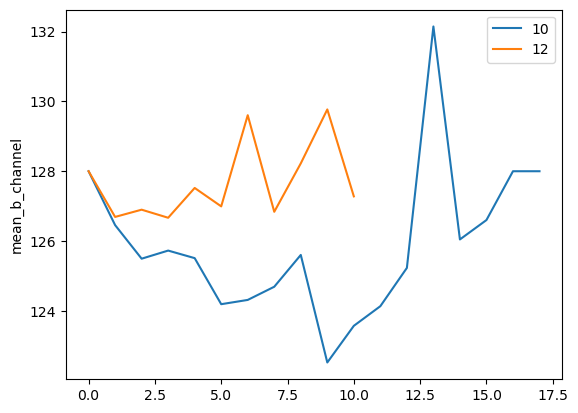

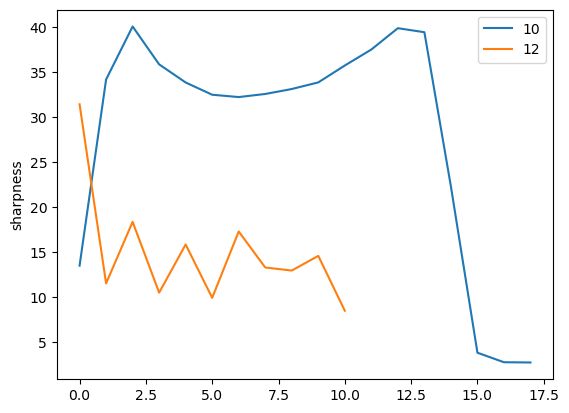

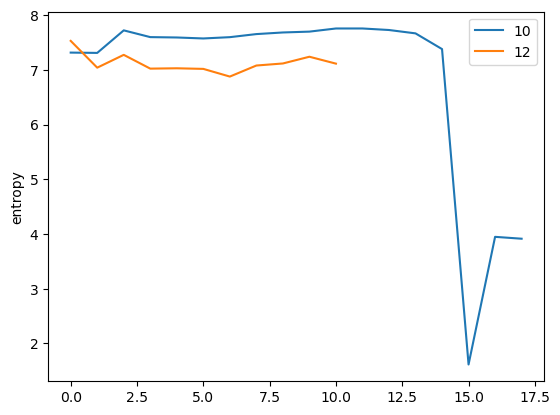

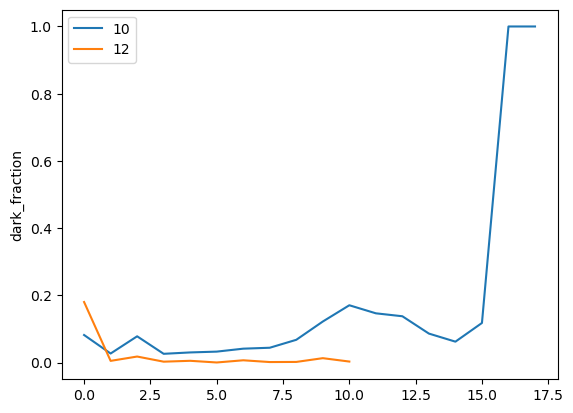

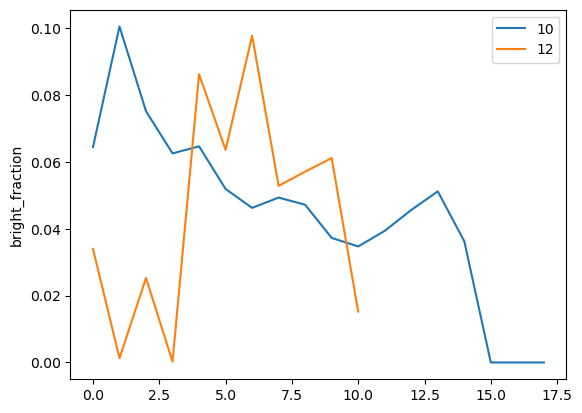

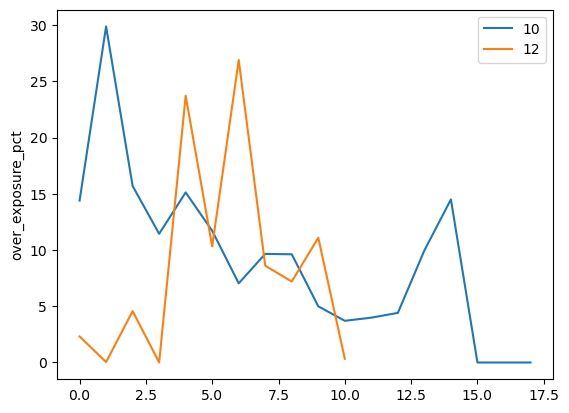

TypeError: no numeric data to plot

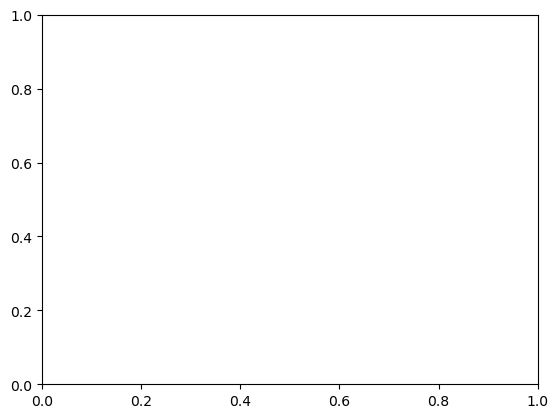

In [97]:
for key in df_feat_11_10.keys():
    plt.figure()
    df_feat_11_10[key].plot(label="10")
    df_feat_11_12[key].plot(label="12")
    plt.ylabel(key)
    plt.legend()
    plt.show()

In [29]:
df_feat_11_12["warm_bright_fraction"]

0     0.000000e+00
1     6.317131e-07
2     3.495479e-05
3     0.000000e+00
4     2.189939e-05
5     0.000000e+00
6     6.969902e-05
7     3.579708e-06
8     1.895139e-06
9     6.464531e-05
10    8.422842e-07
Name: warm_bright_fraction, dtype: float64

In [90]:
def df_selection(df_feat):
    condition = (
            (df_feat['LR_asymmetry_abs'] < 10) &
            (df_feat['mean_brightness'] > 80) &
            (df_feat["sharpness"] > 20)
    )
    print(df_feat[condition]['label'])

In [91]:
df_selection(df_feat_11_10)

1     10/11\n07:50
5     10/11\n11:10
6     10/11\n12:00
12    10/11\n17:00
13    10/11\n17:50
14    10/11\n18:40
Name: label, dtype: object


<Axes: >

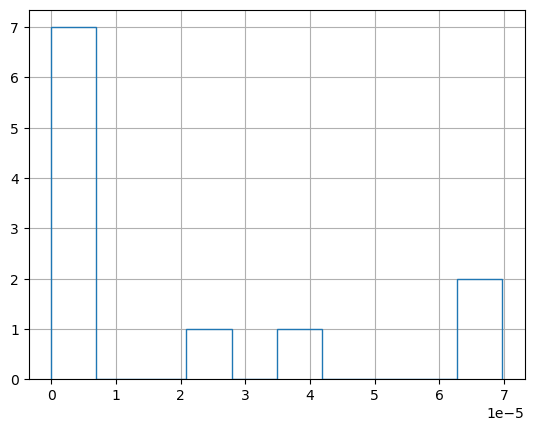

In [77]:
#df_feat_11_10["warm_bright_fraction"].hist(histtype='step')
df_feat_11_12["warm_bright_fraction"].hist(histtype='step')

In [21]:
df_feat[(df_feat['LR_asymmetry_abs'] < 11) & (df_feat['mean_brightness'] > 85)]['label']

0     10/11\n07:00
1     10/11\n07:50
5     10/11\n11:10
6     10/11\n12:00
12    10/11\n17:00
13    10/11\n17:50
14    10/11\n18:40
15    10/11\n19:30
Name: label, dtype: object

<Axes: >

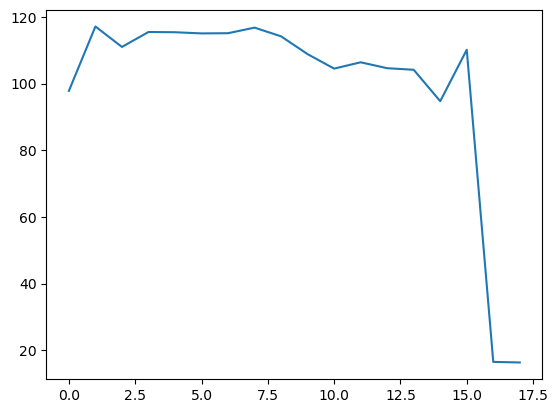

In [22]:
df_feat['mean_brightness'].plot()

In [6]:
images, timestamps, labels, fnames = [], [], [], []

for f in files[::5]:
    images.append(cv2.imread(str(f)))
    ts = parse_timestamp(f)
    labels.append(ts.strftime("%d/%m\n%H:%M"))
    fnames.append(f.name)

i

In [8]:
all_features = []
features_names = None

for img in images:
    feats = extract_all_features(img)
    all_features.append(feats)
    if features_names is None:
        features_names = list(feats.keys())

In [ ]:
len(images)

IndexError: list index out of range

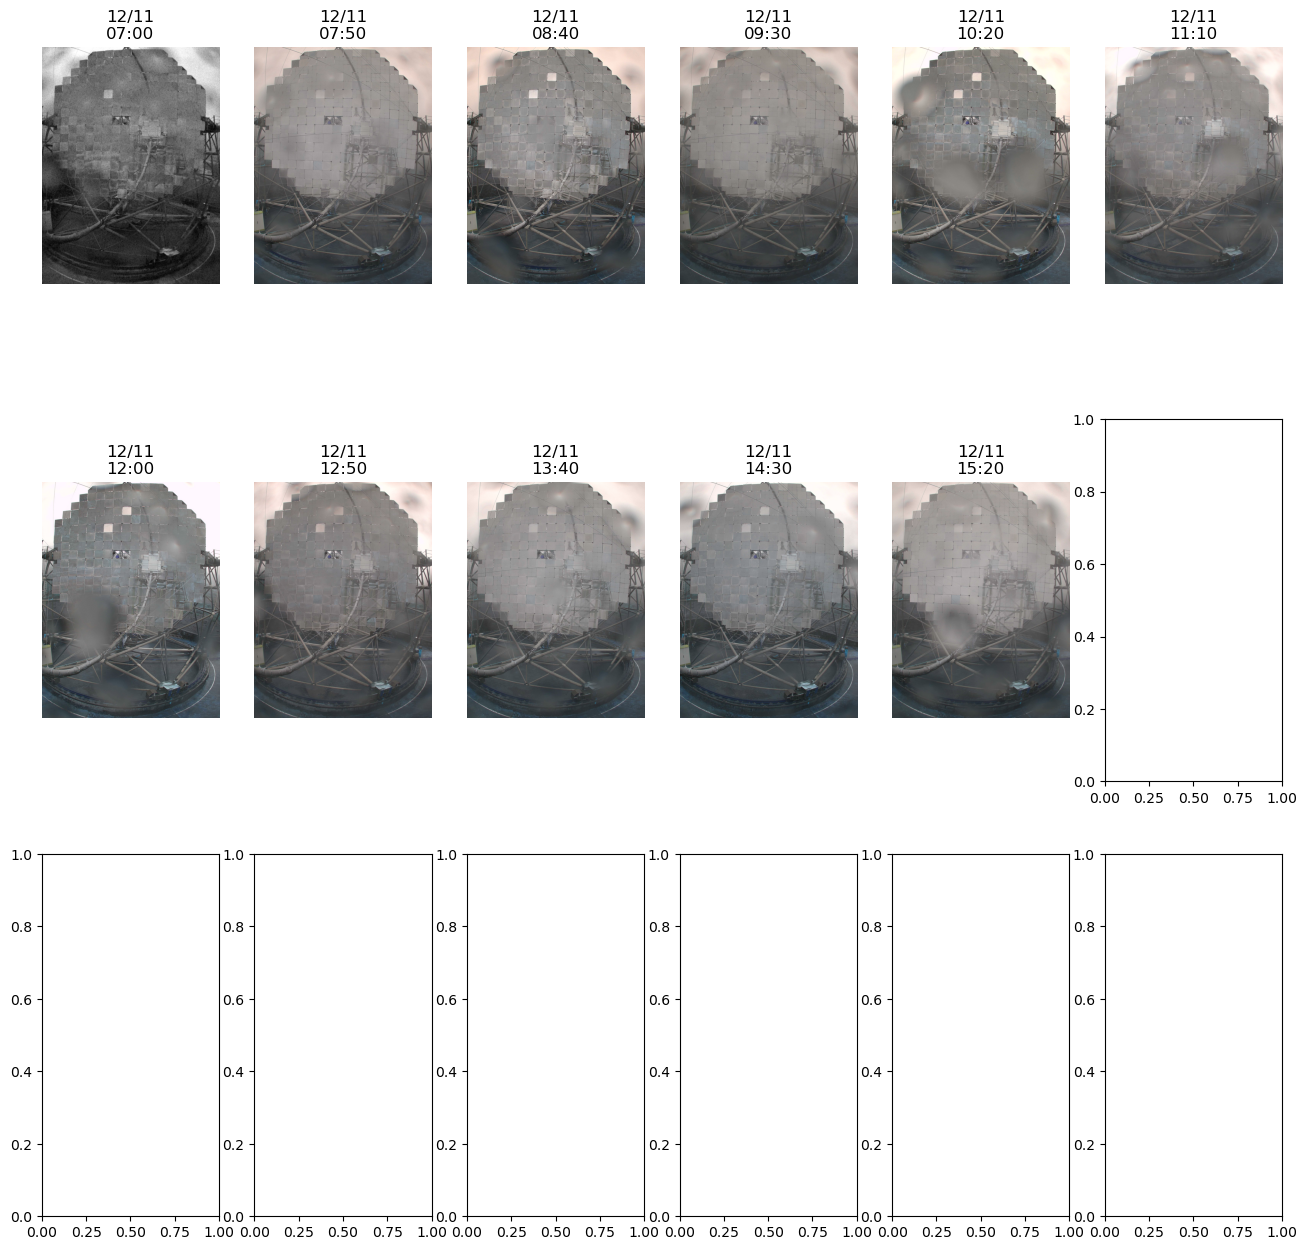

In [9]:
fig, ax = plt.subplots(3, 6, figsize=(16, 16))
axes = ax.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_axis_off()
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
fnames

In [10]:
df = pd.DataFrame(all_features)
df['fnames'] = fnames
df['label'] = labels

In [11]:
df['label'].head()

0    12/11\n07:00
1    12/11\n07:50
2    12/11\n08:40
3    12/11\n09:30
4    12/11\n10:20
Name: label, dtype: object

In [12]:
df.keys()

Index(['mean_brightness', 'std_brightness', 'p10_brightness', 'p90_brightness',
       'dynamic_range', 'warm_bright_fraction', 'bright_saturated_frac',
       'LR_asymmetry', 'LR_asymmetry_abs', 'TB_asymmetry', 'TB_asymmetry_abs',
       'sky_brightness', 'sky_blue_ratio', 'mean_saturation', 'mean_hue',
       'BR_ratio', 'mean_a_channel', 'mean_b_channel', 'sharpness', 'entropy',
       'dark_fraction', 'bright_fraction', 'fnames', 'label'],
      dtype='object')

In [ ]:
df['mean_brightness'].plot()

In [ ]:
df['LR_asymmetry_abs'].plot()

In [ ]:
df[(df['LR_asymmetry_abs'] < 11) & (df['mean_brightness'] > 85)]['label']

In [ ]:
df['warm_bright_fraction']*100

## Image selection
### condition
### Given path -> function() -> return "good" images

In [ ]:
%%sql


In [ ]:
BASE_DIR = "/media/pgliwny/ADATA HD3303/Computer_Vision_system"
img_path = os.path.join(BASE_DIR, "data/MAGIC/IRCam/IRCamera/2025/12/16/IRCamM1T20251216_091547M.jpg")

In [ ]:
img = Image.open(f)
img_array = np.array(img)

plt.imshow(img_array)